In [246]:
import numpy as np
# np.array
# np.where
# np.random
# np.concatenate

In [247]:
data = np.load('mnist.npz')

In [248]:

# np.reshape
x_train_raw = data['x_train']
y_train_raw = data['y_train']
x_test_raw = data['x_test']
y_test_raw = data['y_test']
# print("X_DATAPOINTS_raw = \n", x_train_raw.shape)
from sklearn.decomposition import PCA
x_train_raw_2 = x_train_raw.reshape((x_train_raw.shape[0], -1))
x_test_raw_2 = x_test_raw.reshape((x_test_raw.shape[0], -1))
# print("x_train_raw_2 = \n", x_train_raw_2.shape)

x_train = []
y_train = []
x_test = []
y_test = []
for i in range(len(x_train_raw_2)):
    if (y_train_raw[i] == 0):
        x_train.append(x_train_raw_2[i])
        y_train.append(-1)
    if (y_train_raw[i] == 1):
        x_train.append(x_train_raw_2[i])
        y_train.append(1)
x_train = np.array(x_train)
y_train = np.array(y_train)
print(x_train.shape, y_train.shape)

for i in range(len(x_test_raw_2)):
    if (y_test_raw[i] == 0):
        x_test.append(x_test_raw_2[i])
        y_test.append(-1)
    if (y_test_raw[i] == 1):
        x_test.append(x_test_raw_2[i])
        y_test.append(1)
x_test = np.array(x_test)
y_test = np.array(y_test)
print(x_test.shape, y_test.shape)

(12665, 784) (12665,)
(2115, 784) (2115,)


In [249]:
# split into train and val
indices_pos_1 = np.where(y_train == 1)[0]
indices_neg_1 = np.where(y_train == -1)[0]
# print(len(indices_pos_1), len(indices_neg_1))

np.random.seed(42)
np.random.shuffle(indices_pos_1)
np.random.shuffle(indices_neg_1)

val_pos_1 = indices_pos_1[:1000]
train_pos_1 = indices_pos_1[1000:]
val_neg_1 = indices_neg_1[:1000]
train_neg_1 = indices_neg_1[1000:]

trainX = np.concatenate((x_train[train_pos_1], x_train[train_neg_1]), axis=0)
trainY = np.concatenate((y_train[train_pos_1], y_train[train_neg_1]), axis=0)
valX = np.concatenate((x_train[val_pos_1], x_train[val_neg_1]), axis=0)
valY = np.concatenate((y_train[val_pos_1], y_train[val_neg_1]), axis=0)

train_indices = np.arange(trainX.shape[0])
val_indices = np.arange(valX.shape[0])
np.random.shuffle(train_indices)
np.random.shuffle(val_indices)

trainX = trainX[train_indices]
trainY = trainY[train_indices]
valX = valX[val_indices]
valY = valY[val_indices]

# print(trainX.shape, valX.shape)


In [250]:
# obtain pca from train
pca = PCA(n_components=5)
X = pca.fit_transform(trainX)
print(X.shape)

# X is the final x_train. use X
Y = trainY
# Y is the final y_train. use Y
print(Y.shape)

TEST_X = pca.transform(x_test)
TEST_Y = y_test

(10665, 5)
(10665,)


In [251]:
WeightsX = []
PREVIOUS_DENOMINATOR = 0
for i in range(len(X)):
    WeightsX.append(1/len(X))
    PREVIOUS_DENOMINATOR += (1/len(X))
WeightsX = np.array(WeightsX)
# print(WeightsX)
# print(WeightsX.shape)

# here denominator = sum of weights of all data points
print(PREVIOUS_DENOMINATOR)
# initially this starts of as ~ 1

0.999999999999807


### 1.

In [252]:
def LossPerCut(x_train, WeightsX, y_train, dimensionIndex, split):
    left_pos_1 = 0
    left_neg_1 = 0
    right_pos_1 = 0
    right_neg_1 = 0
    for i in range(len(x_train)):
        if (x_train[i][dimensionIndex] < split):
            if (y_train[i] == 1): left_pos_1 += 1
            elif (y_train[i] == -1): left_neg_1 += 1
        if (x_train[i][dimensionIndex] >= split):
            if (y_train[i] == 1): right_pos_1 += 1
            elif (y_train[i] == -1): right_neg_1 += 1
    left_prediction = 0
    right_prediction = 0
    if (left_pos_1 > left_neg_1):
        left_prediction = 1
    else:
        left_prediction = -1
    if (right_pos_1 > right_neg_1):
        right_prediction = 1
    else:
        right_prediction = -1
    # print(left_neg_1)
    # print(left_pos_1)
    # print(right_neg_1)
    # print(right_pos_1)
    numerator = 0
    # count
    for i in range(len(x_train)):
        # print(f"{i}: {numerator}")
        if (x_train[i][dimensionIndex] < split):
            if (y_train[i] != left_prediction):
                numerator += WeightsX[i]
        if (x_train[i][dimensionIndex] >= split):
            if (y_train[i] != right_prediction):
                numerator += WeightsX[i]
    
    # print(numerator)    
    return numerator, left_prediction, right_prediction


### 2.

In [253]:
# sort and unique
# pick random points

def Split(x_train, y_train, numberOfDimensions):
    SortedDimensionsColumnsMatrix = []
    AllSplitsMatrix = []
    RandomIndicesMatrix = []
    RandomSplitsMatrix = []

    # Change this to change the number of splits being considered for each dimension of a tree
    numberOfSplitsToCompare = 200

    for i in range(numberOfDimensions):
        currentDimensionColumn = x_train[:, i]
        paired = list(zip(currentDimensionColumn, y_train))
        pairedUniqueSorted = sorted(set(paired), key=lambda x: x[0])
        currentDimensionColumn, correspondingLabel = zip(*pairedUniqueSorted)
        SortedDimensionsColumnsMatrix.append(currentDimensionColumn)

        # print(currentDimensionColumn)

        currentSplitArray = []
        for j in range(len(currentDimensionColumn)-1):
            currentSplitArray.append((currentDimensionColumn[j] + currentDimensionColumn[j+1])/2)
        currentSplitArray = np.array(currentSplitArray)
        AllSplitsMatrix.append(currentSplitArray)
        currentRandomIndices = np.random.randint(len(currentDimensionColumn)-1, size=numberOfSplitsToCompare)
        RandomIndicesMatrix.append(currentRandomIndices)

        currentRandomSplits = currentSplitArray[currentRandomIndices]
        RandomSplitsMatrix.append(currentRandomSplits)

    SortedDimensionsColumnsMatrix = np.array(SortedDimensionsColumnsMatrix)
    AllSplitsMatrix = np.array(AllSplitsMatrix) 
    RandomIndicesMatrix = np.array(RandomIndicesMatrix)
    RandomSplitsMatrix = np.array(RandomSplitsMatrix)

    # print(DimensionsColumnsMatrix.shape)
    # print(AllSplitsMatrix.shape)
    # print(RandomIndicesMatrix)
    # print(RandomSplitsMatrix)

    return SortedDimensionsColumnsMatrix, AllSplitsMatrix, RandomIndicesMatrix, RandomSplitsMatrix

In [254]:
# SortedDimensionsColumnsMatrix, AllSplitsMatrix, RandomIndicesMatrix, RandomSplitsMatrix = Split(X, Y, 5)
# print(SortedDimensionsColumnsMatrix.shape)
# print(AllSplitsMatrix.shape)
# print(RandomIndicesMatrix.shape)
# print(RandomSplitsMatrix.shape)

### 3.

In [255]:
# min = 100000
# min_index = (-1, -1)
# for i in range(len(RandomSplitsMatrix)):
#     for j in range(len(RandomSplitsMatrix[i])):
#         if weightedMisclassificationError < min:
#             min = weightedMisclassificationError
#             min_index = (i, j)

# LossPerCut(X, WeightsX, y_train, 0, -200)

def FindingMinLoss(RandomSplitsMatrix, x_train, WeightsX, y_train, denominator):
    LeftAndRightPredictionMatrix = []
    LossMatrix = []
    minLoss = 100000000000000
    minLossSplitValue = -1 
    minLossDimensionIndex = -1
    minLossJ = -1
    for i in range(len(RandomSplitsMatrix)):
        currentLossArray = []
        currentPredictionArray = []
        for j in range(len(RandomSplitsMatrix[i])):
            currentLossNumerator, left_prediction, right_prediction = LossPerCut(x_train, WeightsX, y_train, i, RandomSplitsMatrix[i][j]) 
            currentPredictionArray.append((left_prediction, right_prediction))
            currentLoss = currentLossNumerator / (denominator + 1e-15)
            currentLossArray.append(currentLoss)
            if (currentLoss < minLoss):
                minLoss = currentLoss
                minLossSplitValue = RandomSplitsMatrix[i][j]
                minLossDimensionIndex = i
                minLossJ = j
        LossMatrix.append(currentLossArray)
        LeftAndRightPredictionMatrix.append(currentPredictionArray)

    LossMatrix = np.array(LossMatrix)
    # print(LossMatrix)
    # print(LossMatrix.shape)

    return minLoss, minLossSplitValue, minLossDimensionIndex, minLossJ, LeftAndRightPredictionMatrix



# FindingMinLoss(RandomSplitsMatrix, X, WeightsX, Y, denominator)




### 4.

In [256]:
def UpdatingWeights(x_train, WeightsX, y_train, minLoss, minLossSplitValue, minLossDimensionIndex, minLossJ, LeftAndRightPredictionMatrix, currentDenominator):
    alpha_i = np.log((1-minLoss+1e-15)/(minLoss+1e-15))
    alpha_i = np.clip(alpha_i, a_min=-10, a_max=10)   ########
    # print(alpha_i)
    min_weight_value = 1e-6
    max_weight_value = 1e6
    for i in range(len(x_train)):
        if ((x_train[i][minLossDimensionIndex] < minLossSplitValue) & (y_train[i] != LeftAndRightPredictionMatrix[minLossDimensionIndex][minLossJ][0])):
            # WeightsX[i] = newWeight
            WeightsX[i] = WeightsX[i] * np.exp(alpha_i)
            WeightsX[i] = np.clip(WeightsX[i], a_min=min_weight_value, a_max=max_weight_value)
        if ((x_train[i][minLossDimensionIndex] >= minLossSplitValue) & (y_train[i] != LeftAndRightPredictionMatrix[minLossDimensionIndex][minLossJ][1])):
            # WeightsX[i] = newWeight
            WeightsX[i] = WeightsX[i] * np.exp(alpha_i)
            WeightsX[i] = np.clip(WeightsX[i], a_min=min_weight_value, a_max=max_weight_value)

    newDenominator = np.sum(WeightsX)
    return WeightsX, newDenominator

In [257]:
# minLoss, minLossSplitValue, minLossDimensionIndex, minLossJ, LeftAndRightPredictionMatrix = FindingMinLoss(RandomSplitsMatrix, X, WeightsX, Y, PREVIOUS_DENOMINATOR)
# print(minLoss)
# print(minLossSplitValue)
# print(minLossDimensionIndex)
# print(minLossJ)
# alpha_i = np.log((1-minLoss)/minLoss)
# print(alpha_i)


In [258]:
print(valX.shape)
X_VAL = pca.transform(valX)
print(X_VAL.shape)

Y_VAL = valY

(2000, 784)
(2000, 5)


In [259]:
denominator = PREVIOUS_DENOMINATOR
print(denominator)

0.999999999999807


### 5.

In [260]:
def AccuracyOnVal(X_VAL, Y_VAL, minLossSplitValue, minLossDimensionIndex, minLossJ, LeftAndRightPredictionMatrix):
    PredictionOnVal = []
    for i in range(len(X_VAL)):
        if (X_VAL[i][minLossDimensionIndex] < minLossSplitValue):
            prediction = LeftAndRightPredictionMatrix[minLossDimensionIndex][minLossJ][0]
            PredictionOnVal.append(prediction)
        elif (X_VAL[i][minLossDimensionIndex] >= minLossSplitValue):
            prediction = LeftAndRightPredictionMatrix[minLossDimensionIndex][minLossJ][1]
            PredictionOnVal.append(prediction)

    correct = 0
    for i in range(len(X_VAL)):
        if (PredictionOnVal[i] == Y_VAL[i]):
            correct += 1

    return correct/len(X_VAL)
    # print("Accuracy = ", correct / len(X_VAL))

In [261]:
print(WeightsX)
print(X)
print(Y)
print()

[9.37646507e-05 9.37646507e-05 9.37646507e-05 ... 9.37646507e-05
 9.37646507e-05 9.37646507e-05]
[[-938.16546892  259.47928037 -125.61578642  -19.73491586  752.11235395]
 [-855.37845201  774.87195288  511.88146851  152.85001059 -247.57896542]
 [ 715.35327768  868.89906741 -673.28113846 -713.23838112   -2.5253776 ]
 ...
 [ 898.80959127  111.2737089  -372.36595362 -693.24707902 -460.93304033]
 [1311.11398821  119.46442891 -806.81554114 -345.6087381  -407.96832353]
 [ 828.53991152 -324.9557789   195.80297849  637.16434615 -346.84831164]]
[ 1  1 -1 ... -1 -1 -1]



In [262]:
# print(X)
# print(X.shape)

# print(Y)
# print(Y.shape)

print(X_VAL)
print(X_VAL.shape)

print(Y_VAL)
print(Y_VAL.shape)

[[-8.70764974e+02  7.78150143e+02  5.23087871e+02  1.06072670e+02
  -4.61674585e+02]
 [ 1.44324089e+03 -3.30093334e+02  6.45567544e+02  3.18704074e+02
   3.79866086e+02]
 [-7.35608336e+02 -5.71058891e+02 -4.01486889e-01  5.47579834e+01
  -6.83262018e+02]
 ...
 [-8.38626733e+02  1.01337185e+03  4.84968308e+02  1.57575767e+01
  -2.75921142e+02]
 [-8.41269352e+02 -8.09496353e+02 -3.73811618e+02 -5.48332708e+01
  -1.11217671e+02]
 [ 4.87685620e+02  7.32265146e+02 -5.93263970e+02 -6.71571570e+02
  -3.57500752e+02]]
(2000, 5)
[ 1 -1  1 ...  1  1 -1]
(2000,)


In [263]:
# not updating weights properly i think.

In [264]:
NumberOfTrees = 300  # Number of Trees!
ValAccuracyArray = []
best_val_accuracy = 0
best_tree = None
for i in range(NumberOfTrees):  
    print(f"{i+1} stump")
    a, b, c, RandomSplitsMatrix = Split(X, Y, 5)
    minLoss, minLossSplitValue, minLossDimensionIndex, minLossJ, LeftAndRightPredictionMatrix = FindingMinLoss(RandomSplitsMatrix, X, WeightsX, Y, denominator)
    # here calculate the accuracy on val.
    ValAccuracy = AccuracyOnVal(X, Y, minLossSplitValue, minLossDimensionIndex, minLossJ, LeftAndRightPredictionMatrix)
    ValAccuracyArray.append(ValAccuracy)
    print(ValAccuracy)

    if (ValAccuracy > best_val_accuracy):
        best_val_accuracy = ValAccuracy
        best_tree = (minLossSplitValue, minLossDimensionIndex, minLossJ, LeftAndRightPredictionMatrix)
    
    WeightsX, denominator = UpdatingWeights(X_VAL, WeightsX, Y_VAL, minLoss, minLossSplitValue, minLossDimensionIndex, minLossJ, LeftAndRightPredictionMatrix, denominator)

    # print(WeightsX)
    # print(denominator)
    
# print(WeightsX)
# print(denominator)

1 stump


0.9951242381622128
2 stump
0.9954055321143929
3 stump
0.9949367088607595
4 stump
0.9894045944678856
5 stump
0.9951242381622128
6 stump
0.9954055321143929
7 stump
0.9939990623534928
8 stump
0.993905297702766
9 stump
0.9950304735114862
10 stump
0.9954055321143929
11 stump
0.9922175339896859
12 stump
0.9954055321143929
13 stump
0.994186591654946
14 stump
0.9954055321143929
15 stump
0.9950304735114862
16 stump
0.9954055321143929
17 stump
0.9954055321143929
18 stump
0.9953117674636662
19 stump
0.9939990623534928
20 stump
0.9935302390998594
21 stump
0.9953117674636662
22 stump
0.9953117674636662
23 stump
0.9905297702766057
24 stump
0.9924050632911392
25 stump
0.9942803563056728
26 stump
0.9954992967651195
27 stump
0.9953117674636662
28 stump
0.994186591654946
29 stump
0.9954055321143929
30 stump
0.9950304735114862
31 stump
0.9953117674636662
32 stump
0.9954992967651195
33 stump
0.9954055321143929
34 stump
0.9944678856071261
35 stump
0.9953117674636662
36 stump
0.9952180028129395
37 stump
0.9

In [268]:
if best_tree:
    minLossSplitValue, minLossDimensionIndex, minLossJ, LeftAndRightPredictionMatrix = best_tree
    TestAccuracy = AccuracyOnVal(TEST_X, TEST_Y, minLossSplitValue, minLossDimensionIndex, minLossJ, LeftAndRightPredictionMatrix)
    print(f"Test Accuracy: {TestAccuracy}")
    # print(best_tree)
else:
    print("No tree was found.")

Test Accuracy: 0.9962174940898345
(-197.37325252044315, 0, 176, [[(1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, 1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, 1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, 1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, 1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, 1), (1, -1), (1, -1), (1, 1), (1, -1), (1, -1), (1, 1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, 1), (1, -1

In [271]:
for i in range(len(ValAccuracyArray)):
    print(f"{i+1} stump accuracy: ", ValAccuracyArray[i])


1 stump accuracy:  0.9951242381622128
2 stump accuracy:  0.9954055321143929
3 stump accuracy:  0.9949367088607595
4 stump accuracy:  0.9894045944678856
5 stump accuracy:  0.9951242381622128
6 stump accuracy:  0.9954055321143929
7 stump accuracy:  0.9939990623534928
8 stump accuracy:  0.993905297702766
9 stump accuracy:  0.9950304735114862
10 stump accuracy:  0.9954055321143929
11 stump accuracy:  0.9922175339896859
12 stump accuracy:  0.9954055321143929
13 stump accuracy:  0.994186591654946
14 stump accuracy:  0.9954055321143929
15 stump accuracy:  0.9950304735114862
16 stump accuracy:  0.9954055321143929
17 stump accuracy:  0.9954055321143929
18 stump accuracy:  0.9953117674636662
19 stump accuracy:  0.9939990623534928
20 stump accuracy:  0.9935302390998594
21 stump accuracy:  0.9953117674636662
22 stump accuracy:  0.9953117674636662
23 stump accuracy:  0.9905297702766057
24 stump accuracy:  0.9924050632911392
25 stump accuracy:  0.9942803563056728
26 stump accuracy:  0.99549929676511

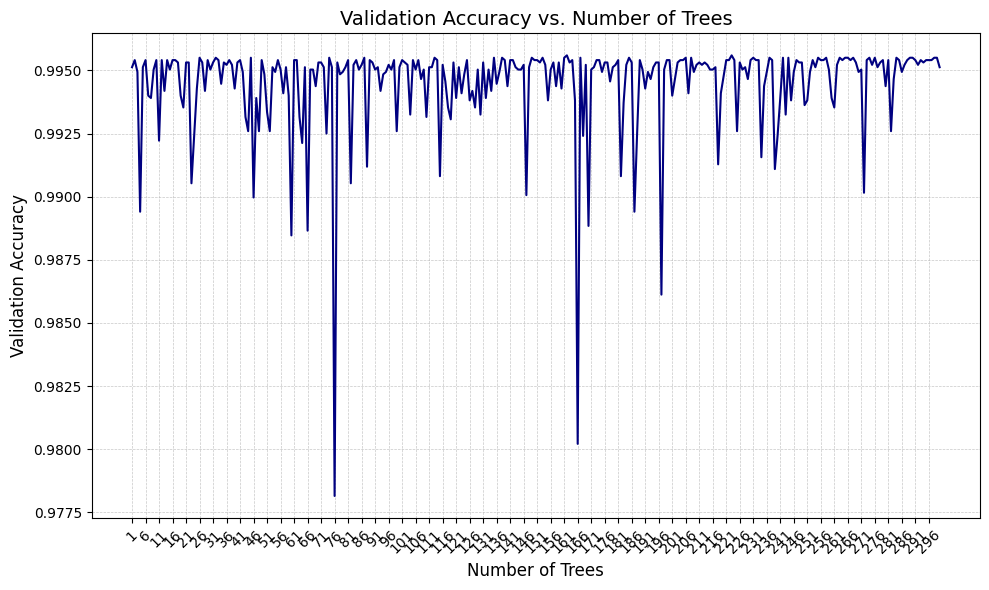

In [273]:
import matplotlib.pyplot as plt
# plt.figure(figsize=(10, 6))
# plt.plot(range(1, len(ValAccuracyArray) + 1), ValAccuracyArray, marker='o', linestyle='-', color='blue')
# plt.title('Validation Accuracy vs. Number of Trees')
# plt.xlabel('Number of Trees')
# plt.ylabel('Validation Accuracy')
# plt.grid(True)
# plt.xticks(range(1, len(ValAccuracyArray) + 1))
# plt.show()

# # Printing the maximum accuracy value
# max_accuracy = max(ValAccuracyArray)
# max_accuracy
plt.figure(figsize=(10, 6), dpi=100)  # Higher dpi for better resolution
plt.plot(range(1, len(ValAccuracyArray) + 1), ValAccuracyArray, linestyle='-', color='navy')  # Solid line
plt.title('Validation Accuracy vs. Number of Trees', fontsize=14)
plt.xlabel('Number of Trees', fontsize=12)
plt.ylabel('Validation Accuracy', fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)  # Lighter grid
plt.xticks(np.arange(1, len(ValAccuracyArray) + 1, step=5), rotation=45)  # Less crowded x-axis ticks
plt.tight_layout()  # Adjust layout to fit all elements
plt.show()